# Simple fMRI preprocessing pipeline
This notebook describes a simple preprocessing pipeline for fMRI data, using the [nipype](http://nipy.org/nipype/) environment/package (Gorgolewski K., et al., 2011, Front. Neurinform. 5:13), in which a combination of FSL-software and custom Python scripts are used. 

Lukas Snoek, University of Amsterdam (lukassnoek@gmail.com)

## Packages and settings
Below, necessary packages are imported and some pipeline-specific variables are defined.

In [1]:
    # Importing necessary packages
    import os
    import os.path as op
    import glob
    import nipype
    import matplotlib.pyplot as plt
    import nipype.interfaces.fsl as fsl
    import nipype.pipeline.engine as pe
    import nipype.interfaces.utility as util
    import nibabel as nib
    from IPython.display import Image
    from nipype.interfaces.utility import IdentityInterface
    from nipype.interfaces.io import SelectFiles, DataSink
    from IPython.display import Image

    # Importing of custom nodes from spynoza packages; assumes that spynoza is installed:
    # pip install git+https://github.com/spinoza-centre/spynoza.git@master
    from spynoza.nodes import apply_sg_filter, find_middle_run, get_scaninfo
    from spynoza.BIDS_tools import fetch_example_data

    %matplotlib inline

## Setting up the project structure
To use Nipype effectively, it's nice to have your data structured in a way such that it is easy to glob
files. Here, the `fetch_testdata` tool can be used to download a dataset that's already in BIDS-format which has a sensible structure. 

In [2]:
project_dir = op.join(op.expanduser('~'), 'nipype_example')

if not op.isdir(project_dir):
    os.makedirs(project_dir)

data_dir = fetch_example_data(directory=project_dir, type='3T')

 The file you will download is ~120 MB; do you want to continue? (Y / N): Y
Data is located at: /home/lukas/nipype_example/testdata_3T


## Setting up the workflow
Definition of nodes within pipeline + inputs (infosource / selectfiles) + outputs (datasink)

In [4]:
# i/o
sess_list = [op.basename(s) for s in glob.glob(op.join(data_dir, '*', 'ses-*'))] 
sub_list = [op.basename(s) for s in glob.glob(op.join(data_dir, 'sub*'))] 

derivatives_dir = op.join(project_dir, 'derivatives2')
datasink_name = '' # filled in by infosource

# Analysis parameters
frac_T1 = 0.4
frac_epi = 0.2
robust_bet = True
fwhm = 5.0
mcflt_cost = 'mutualinfo'

### Input/output nodes
First, the input nodes (infosource / selectfiles) and output nodes (datasink) are defined.

In [5]:
# Infosource simply distributes iterables (here: runs, but could also be subjects) for parallel processing
infosource = pe.Node(IdentityInterface(fields=['sub_id', 'sess_id']), name="infosource")
infosource.iterables = [('sub_id', sub_list), ('sess_id', sess_list)] 
# you can also specify other iterables, such as models or runs 

# The template is used to glob files
template = {
    'func': op.join(data_dir, '{sub_id}', '{sess_id}', 'func', '*.nii.gz'),
    # Note that only session 'ses-02' is specifically defined, because only this session has a T1!
    'T1': op.join(data_dir, '{sub_id}', 'ses-02', 'anat', '*T1w.nii.gz'),
    'T2': op.join(data_dir, '{sub_id}', '{sess_id}', 'anat', '*T2w.nii.gz')
}

# selectfiles actually 'collects' the filepaths using the template
selectfiles = pe.Node(SelectFiles(template, base_directory=data_dir), name="selectfiles")

# The datasink node is used to store results from the preprocessing pipeline
# N.B.: within the 'derivates' directory, a 'working-directory' is also created (next to the datasink dir)
datasink = pe.Node(DataSink(base_directory=derivatives_dir, container=datasink_name), name="datasink")
datasink.inputs.parameterization = False
#datasink.inputs.substitutions = substitutions

### T1 processing stream
Some nodes for reorientation etc.

In [6]:
reorient_T1 = pe.Node(interface=fsl.Reorient2Std(), name='reorient_T1')
bet_T1 = pe.Node(interface=fsl.BET(frac=frac_T1, robust=robust_bet), name='bet_T1')
fast = pe.Node(interface=fsl.FAST(), name='segment') # white/gray matter separation

### T2 processing stream
Below, some nodes are defined to preprocess the T2-weighted images.

In [7]:
reorient_T2 = pe.Node(interface=fsl.Reorient2Std(), name='reorient_T2')
bet_T2 = pe.Node(interface=fsl.BET(frac=0.4, robust=robust_bet), name='bet_T2')

### EPI processing stream
Below, some nodes are defined for basic BOLD-epi preprocessing.

In [8]:
reorient_epi = pe.Node(interface=fsl.Reorient2Std(), name='reorient_epi')
bet_epi = pe.Node(interface=fsl.BET(frac=frac_epi, functional=True), name='bet_epi')
mcflirt = pe.Node(interface=fsl.MCFLIRT(cost=mcflt_cost, interpolation='sinc', stages=3, save_plots=True),
                            name='mcflirt')

plot_motion = pe.Node(interface=fsl.PlotMotionParams(in_source='fsl'),
                        name='plot_motion')

# Here, we define an iterable for the plot_motion node, instructing to calculate both
# 'rotations' and 'translations' (options for the 'plot_type' argument)
plot_motion.iterables = ('plot_type', ['rotations', 'translations'])

slicetimer = pe.Node(interface=fsl.SliceTimer(interleaved=False), 
                     name='slicetimer')

smooth = pe.Node(interface=fsl.IsotropicSmooth(fwhm=fwhm), 
                 name='smooth')

# This is a custom function from the Spynoza package!
# The function can easily be converted to a node using the nipype.interfaces.utils.Function class.
sgfilter = pe.Node(util.Function(input_names=['in_file'],
                                    output_names=['out_file'],
                                    function=apply_sg_filter),
                      name='sgfilter')

### Misc. nodes

In [9]:
extract_scaninfo = pe.Node(util.Function(input_names=['in_file'],
                                         output_names=['TR', 'shape', 'dyns', 'voxsize', 'affine'],
                                         function=get_scaninfo),
                           name='extract_scaninfo')

### Connect nodes together!

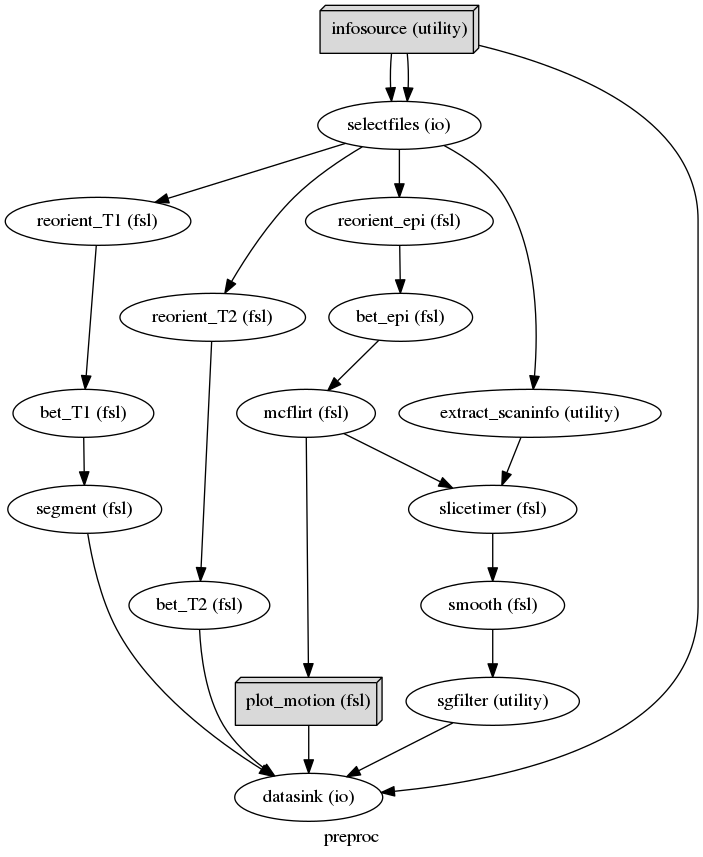

In [10]:
preproc = pe.Workflow(name='preproc')
preproc.base_dir = derivatives_dir
preproc.connect(infosource, 'sess_id', selectfiles, 'sess_id')
preproc.connect(infosource, 'sub_id', selectfiles, 'sub_id')
preproc.connect(infosource, 'sub_id', datasink, 'container')
    
preproc.connect(selectfiles, 'T1', reorient_T1, 'in_file')
preproc.connect(reorient_T1, 'out_file', bet_T1, 'in_file')
preproc.connect(bet_T1, 'out_file', fast, 'in_files')
preproc.connect(fast, 'tissue_class_files', datasink, 'fast')

preproc.connect(selectfiles, 'T2', reorient_T2, 'in_file')
preproc.connect(reorient_T2, 'out_file', bet_T2, 'in_file')
preproc.connect(bet_T2, 'out_file', datasink, 'bett2')

preproc.connect(selectfiles, 'func', reorient_epi, 'in_file')
preproc.connect(reorient_epi, 'out_file', bet_epi, 'in_file')
preproc.connect(bet_epi, 'out_file', mcflirt, 'in_file')

preproc.connect(mcflirt, 'out_file', slicetimer, 'in_file')
preproc.connect(mcflirt, 'par_file', plot_motion, 'in_file')
preproc.connect(plot_motion, 'out_file', datasink, 'mcplots')

preproc.connect(slicetimer, 'slice_time_corrected_file', smooth, 'in_file')
preproc.connect(smooth, 'out_file', sgfilter, 'in_file')
preproc.connect(selectfiles, 'func', extract_scaninfo, 'in_file')
preproc.connect(extract_scaninfo, 'TR', slicetimer, 'time_repetition')
preproc.connect(sgfilter, 'out_file', datasink, 'fullypreproc')

preproc.write_graph()
Image(filename=op.join(derivatives_dir, preproc.name, 'graph.dot.png'))

# Check out a more detailed graph by:
#Image(filename=os.path.join(project_dir, preproc.name, 'graph_detailed.dot.png'))

In [11]:
# Run workflow!
#preproc.config = {'execution' : {'stop_on_first_crash' : True,
#                                 'keep_inputs': True,
#                                 'remove_unnecessary_outputs': True}}
graph = preproc.run('MultiProc', plugin_args={'n_procs': 1})